### Compute and plot spectra of stochastically-generated data

In [1]:
import numpy as np
import scipy.signal
import scipy as sp
import sys

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../src/')
from aux_func import *
import aux_func_3dfields as my


#import seaborn as sns
#sns.set(style="darkgrid")
#sns.set(style="whitegrid")

from pyspec import spectrum


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 15 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 15 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 15 days


In [44]:
plt.rcParams.update({'font.size': 10
    , 'legend.markerscale': 1., 'axes.titlesize': 10, 'axes.labelsize' : 10,
      'legend.fontsize' : 8,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

In [27]:
color1 = '#ff6347'
color2 = '#6495ed'
color3 = '#ffd700'
color4 = '#8470ff'
color5 = '#ff69b4'
color6 = '#006400'

lw1=3
aph=.7

In [28]:
# parameters
L = 800.    # [km]
dx = 2.5
dk = 1./L/dx
kNy = 1./(2.*dx)

# create isotropic spectral ramp
k = np.arange(-kNy,kNy,dk)
k = k/k[-1] # non-dimensional form to reduce numerical error
ki,li = np.meshgrid(k,k)
K = np.sqrt((ki**2) + (li**2))

kt = 1.e-10  # low wavenumber cutoff to avoid numerical error 
Esyn2D = (1./K**3)/K
Esyn2D = np.ma.masked_array(Esyn2D,K<=kt)
Esyn2D2 = (1./K**2)/K
Esyn2D2 = np.ma.masked_array(Esyn2D2,K<=kt)

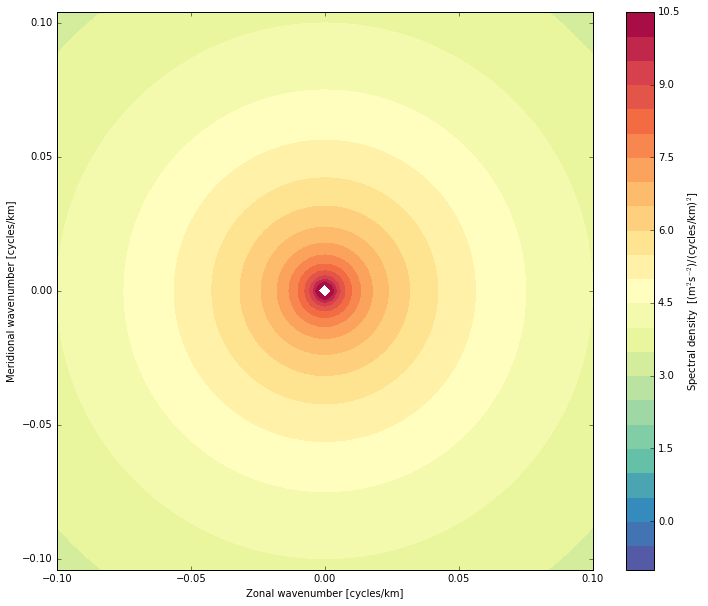

In [29]:
# plot 2D spectral ramp (K^{-3} rolloff)
fig = plt.figure(facecolor='w', figsize=(12.,10.))
plt.contourf(k,k,np.log10(Esyn2D), 25,cmap='Spectral_r')
cb = plt.colorbar()
cb.set_label(u'Spectral density  [(m$^2$s$^{-2}$)/(cycles/km)$^2$]')
plt.axis('equal')
plt.xlim(-.1,.1)
plt.ylim(-.1,.1)

plt.xlabel('Zonal wavenumber [cycles/km]')
plt.ylabel('Meridional wavenumber [cycles/km]')
plt.savefig('figs/2d_Esyn') 

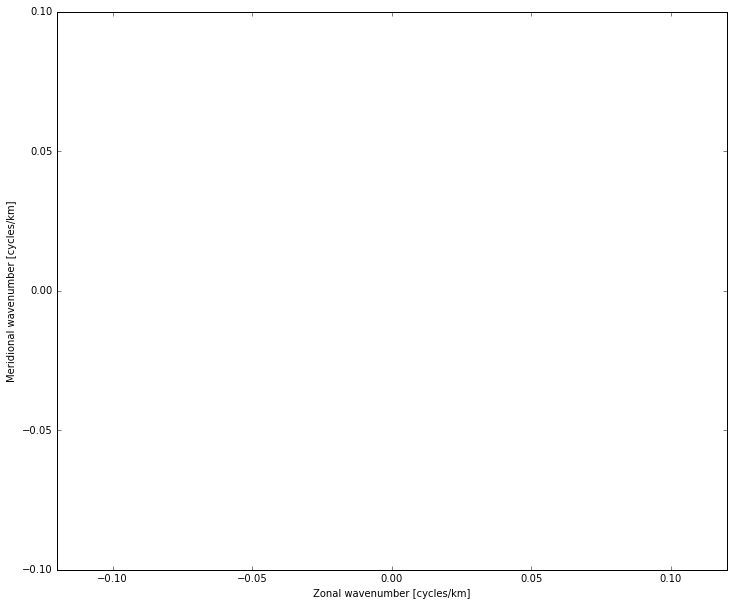

In [30]:
# plot 2D spectral ramp (K^{-2} rolloff)
fig = plt.figure(facecolor='w', figsize=(12.,10.))
#plt.contour(k,k,np.log10(Esyn2D2), 25)#,cmap='Spectral_r')
plt.contour(np.log10(Esyn2D2))
#cb = plt.colorbar()
#cb.set_label(u'Spectral density  [(m$^2$s$^{-2}$)/(cycles/km)$^2$]')
plt.axis('equal')
plt.xlim(-.1,.1)
plt.ylim(-.1,.1)

plt.xlabel('Zonal wavenumber [cycles/km]')
plt.ylabel('Meridional wavenumber [cycles/km]')
plt.savefig('figs/2d_Esyn2')        

In [31]:
# create random phase
n = 10
ix,jx=Esyn2D.shape
pha = 2*np.pi*(np.random.rand(ix*jx*n).reshape(ix,jx,n))  # assume phases are correlated
ii = np.complex(0,1)
pha = np.cos(pha) + ii*np.sin(pha)
Esyn2D = np.repeat(Esyn2D,n).reshape(ix,jx,n)
Esyn2D = np.sqrt(Esyn2D)*pha
Esyn2D2 = np.repeat(Esyn2D2,n).reshape(ix,jx,n)
Esyn2D2 = np.sqrt(Esyn2D2)*pha

# back to fourier coefs
an = np.fft.fftshift(Esyn2D)*((dk*dk)*((ix*jx)**2))
an2 = np.fft.fftshift(Esyn2D2)*((dk*dk)*((ix*jx)**2))

# back to physical space (i.e., create synthetic u and v)
U = np.fft.ifft2(an,axes=(0,1))
U = 2.5*(U/U.max())   # normalize to have the same level of energy as in llc4320
u = np.real(U)
v = np.imag(U)

print u.shape

U2 = np.fft.ifft2(an2,axes=(0,1))
U2 = 2.5*(U2/U2.max())
u2 = np.real(U2)
v2 = np.imag(U2)

up,vp,us,vs = ps(u,v,dx,dx)
up2,vp2,us2,vs2 = ps(u2,v2,dx,dx)

# filter divergent part of the flow (cut-off about 40 km)
nx = 40/dx
ny = 40/dx
x, y = np.mgrid[-nx/2:nx/2, -ny/2:ny/2]
    
rx = 40./dx
ry = 40./dx

g = np.exp( -  ( (x/rx)**2 + (y/ry)**2 ) )
g = g/g.sum()

ix,jx,kx = up.shape
upf = np.zeros(up.shape)
vpf = np.zeros(vp.shape)
upf2 = np.zeros(up2.shape)
vpf2 = np.zeros(vp2.shape)

(800, 800, 10)


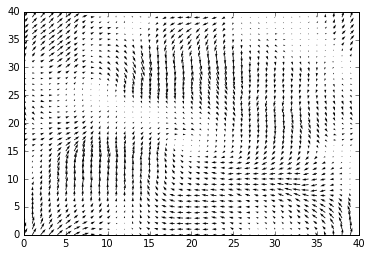

In [32]:
plt.quiver(u[::20,::20,0],v[::20,::20,0])

In [33]:
# save for later use
np.savez('synthetic_uv.npz',up=u[:,:,0],vp=vp[:,:,0],us=us[:,:,0],vs=vs[:,:,0])

In [34]:
for i in range(kx):
    upm = up[:,:,i].mean()
    upi = up[:,:,i]
    upf[:,:,i] = sp.signal.convolve2d(upi-upm,g, mode='same') + upm 
    vpm = vp[:,:,i].mean()
    vpi = vp[:,:,i]
    vpf[:,:,i] = sp.signal.convolve2d(vpi-vpm,g, mode='same') + vpm 
    del upi, upm

    upm = up2[:,:,i].mean()
    upi = up2[:,:,i]
    upf2[:,:,i] = sp.signal.convolve2d(upi-upm,g, mode='same') + upm 
    vpm = vp2[:,:,i].mean()
    vpi = vp2[:,:,i]
    vpf2[:,:,i] = sp.signal.convolve2d(vpi-vpm,g, mode='same') + vpm 
    del upi, upm

# the divergent part associated with 'small scales'
ud = up-upf
vd = vp-vpf
ud2 = up2-upf2
vd2 = vp2-vpf2

# make the flow slightly div.

nd = 1.  # div. to non-div variance ratio
uu = nd*ud + us
vv = nd*vd + vs

nd = .25*(ud.std()/ud2.std())  # signal to noise ratio in the <40 km subrange
uu2 = nd*ud2 + us
vv2 = nd*vd2 + vs

EUn2,l2d,k2d,_,_,_,_=spec_est2(uu2,dx,dx,win=True)
EVn2,_,_,_,_,_,_=spec_est2(vv2,dx,dx,win=True)
E2D_n2=(EUn2+EVn2)/2.

EUn,l2d,k2d,_,_,_,_=spec_est2(uu,dx,dx,win=True)
EVn,_,_,_,_,_,_=spec_est2(vv,dx,dx,win=True)
E2D_n=(EUn+EVn)/2.

# add white noise and divergent flow at small scales
nn= 0.0  # noise-to-signal ratio
Au = nn*us.std()
Av = nn*vs.std()
ix,jx,kx = us.shape
nu = Au*(np.random.randn(ix*jx*kx)).reshape(ix,jx,kx)
nv = Av*(np.random.randn(ix*jx*kx)).reshape(ix,jx,kx)

# spectral window
ix,jx,kx=u.shape
window = np.repeat(np.hanning(ix),jx).reshape(ix,jx)
window=np.repeat(window,kx).reshape(ix,jx,kx)

# total flow
Eut,kut,dku,kuNy = my.spec_est_meridional(u*window,dx)
Evt,kvt,dkv,kvNy = my.spec_est_meridional(v*window,dx)
Evt=Evt.mean(axis=1)
Eut=Eut.mean(axis=1)

# horizontally non-divergent
Eu,ku,dku,kuNy = my.spec_est_meridional(us*window,dx)
Ev,kv,dkv,kvNy = my.spec_est_meridional(vs*window,dx)
Ev=Ev.mean(axis=1)
Eu=Eu.mean(axis=1)

# add divergent flow at small scales and random noise
Eun,_,_,_ = my.spec_est_meridional((uu+nu)*window,dx)
Evn,_,_,_ = my.spec_est_meridional((vv+nv)*window,dx)
Evn=Evn.mean(axis=1)
Eun=Eun.mean(axis=1)
Eun2,_,_,_ = my.spec_est_meridional((uu2+nu)*window,dx)
Evn2,_,_,_ = my.spec_est_meridional((vv2+nv)*window,dx)
Evn2=Evn2.mean(axis=1)
Eun2=Eun2.mean(axis=1)

Ek = (np.sum(Esyn2D,axis=1)*dk)[k.size/2:]
El = (np.sum(Esyn2D,axis=0)*dk)[k.size/2:]
k = k[k.size/2:]

# add random noise
Enoise=.1*((Ev[240]+Eu[240])/2.)*np.ones(Ev.size)
Eunn,Evnn=Eu+Enoise,Ev+Enoise

# mask very low and very high wavenumbers
L = 1./ku
fm = ((L<=5)|(L>=800))
Eu = np.ma.masked_array(Eu,fm)
Ev = np.ma.masked_array(Ev,fm)
Eun = np.ma.masked_array(Eun,fm)
Evn = np.ma.masked_array(Evn,fm)
Eun2 = np.ma.masked_array(Eun2,fm)
Evn2 = np.ma.masked_array(Evn2,fm)

# compute ratios in an arbitrary range
f = ((L>=40)&(L<=200))
rn = ((Eun/Evn)[f]).mean()
r = ((Eu/Ev)[f]).mean()
rn2 = ((Eun2/Evn2)[f]).mean()

# BCF decomposition of synthetic data
Kpsi_nd,Kphi_nd,kK=bcf(kv,Eu,Ev)
Kpsi_d1,Kphi_d1,_=bcf(kv,Eun,Evn)
Kpsi_d2,Kphi_d2,_=bcf(kv,Eun2,Evn2)

In [35]:
def add_second_axis(ax1):
    """ Add a x-axis at the top of the spectra figures """
    ax2 = ax1.twiny() 
    ax2.set_xscale('log')
    ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
    kp = 1./np.array([500.,200.,100.,40.,20.,10.,5.])
    lp=np.array([500,200,100,40,20,10,5])
    ax2.set_xticks(kp)
    ax2.set_xticklabels(lp)
    plt.xlabel('Wavelength [km]')

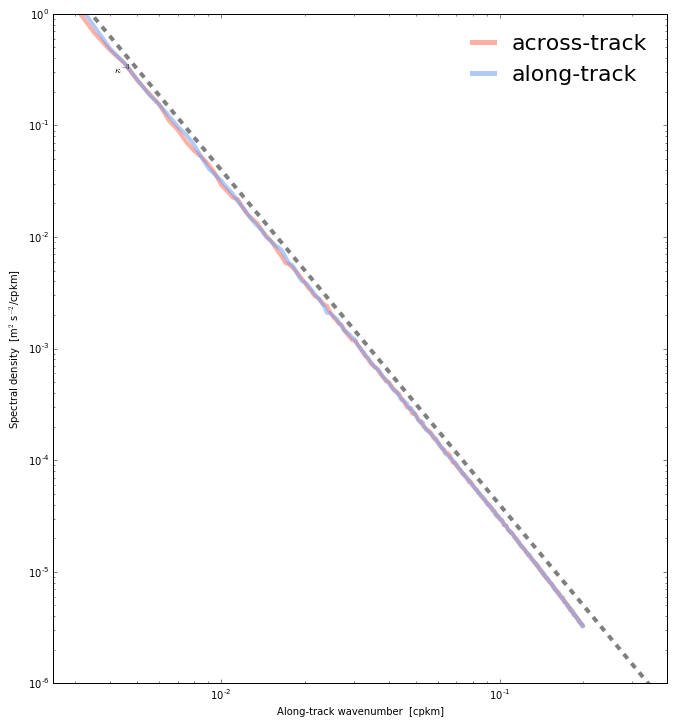

In [36]:
# -2 and -3 slopes in the loglog space
ks2 = np.array([1.e-3,1.])
Es2 = .5e-6*(ks2**(-2))

ks3 = np.array([1.e-3,1.])
Es3 = .4e-7*(ks3**(-3))

# nd + d
fig = plt.figure(facecolor='w', figsize=(11.,12.))
plt.loglog(kut,Eut,color=color1,label='across-track',linewidth=4.,alpha=.5)
plt.loglog(kvt,Evt,color=color2,label='along-track',linewidth=4.,alpha=.5)
plt.loglog(ks3,Es3,'--',color='k',linewidth=4.,alpha=.5)
plt.text(0.0041159850623393082, 0.29427271762092821,u'$\kappa^{-3}$')
plt.axis((1./(400),1./2.5,1.e-6,1.))
plt.ylabel('Spectral density  [m$^2$ s$^{-2}$/cpkm]')
plt.xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=1,title= u'', prop={'size':22}, numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)
figtit = 'figs/EuEv_synthetic_total.png'
plt.savefig(figtit,format='png', bbox_inches='tight')


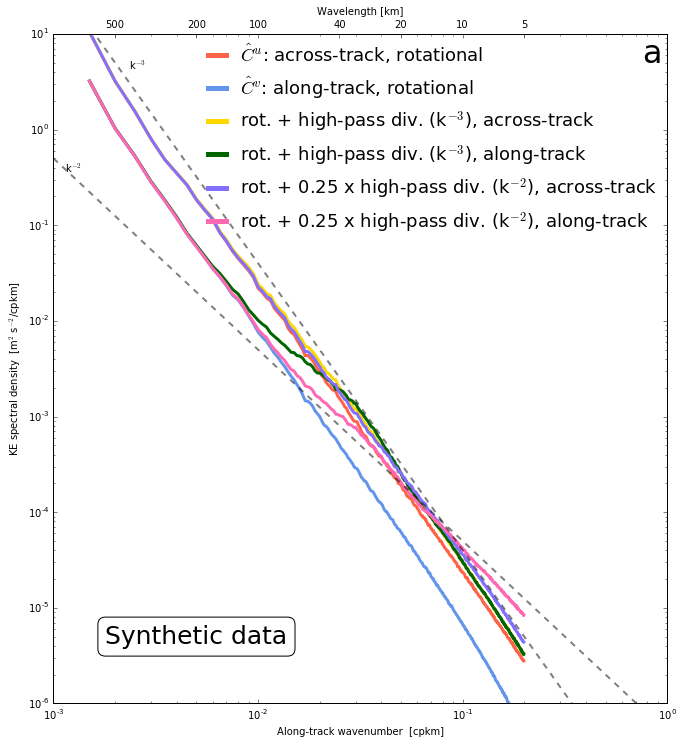

In [37]:

# nd + high-pass d
fig = plt.figure(facecolor='w', figsize=(11.,12.))
ax1 = fig.add_subplot(111)
p1,= ax1.loglog(ku,Eu,color=color1,label=u'$\hat{C}^u$: across-track, rotational',linewidth=3.)
ax1.loglog(kv,Ev,color=color2,label=u'$\hat{C}^v$: along-track, rotational',linewidth=3.)
p2, =ax1.loglog(ku,Eun,color=color3,label=u'rot. + high-pass div. (k$^{-3}$), across-track',linewidth=3.)
plt.loglog(kv,Evn,color=color6,label=u'rot. + high-pass div. (k$^{-3}$), along-track',linewidth=3.)
p3, = ax1.loglog(ku,Eun2,'-',color=color4,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), across-track',linewidth=3.)
ax1.loglog(kv,Evn2,'-',color=color5,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), along-track',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'--', color='k',linewidth=2.,alpha=.5)
ax1.loglog(ks3,Es3,'--', color='k',linewidth=2.,alpha=.5)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'k$^{-3}$')
ax1.text(0.0011367633953758597, 0.35651953657755464,u'k$^{-2}$')
ax1.set_ylabel('KE spectral density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=(.24,.69),title= u'', prop={'size':18,}, numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)

ax1.axis((1./1.e3,1.,1./1.e6,1.e1))

ax1.text(0.75, 5., "a", fontsize=32)

add_second_axis(ax1)

ax1.text(.5/1.e2, 5./1.e6, "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

figtit = 'figs/EuEv_synthetic.png'
plt.savefig(figtit,format='png', bbox_inches='tight')

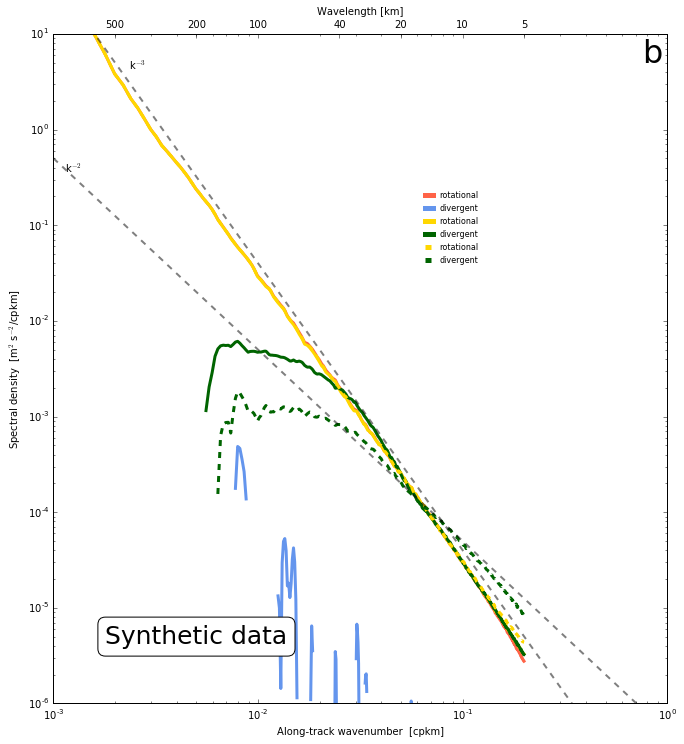

In [38]:
# nd + high-pass d: BCF decomposition
fig = plt.figure(facecolor='w', figsize=(11.,12.))
ax1 = fig.add_subplot(111)
p1,= ax1.loglog(kK,Kpsi_nd,color=color1,label=u'rotational',linewidth=3.)
ax1.loglog(kK,Kphi_nd,color=color2,label=u'divergent',linewidth=3.)
p2, =ax1.loglog(kK,Kpsi_d1,color=color3,label=u'rotational',linewidth=3.)
ax1.loglog(kK,Kphi_d1,color=color6,label=u'divergent',linewidth=3.)
p3, = ax1.loglog(kK,Kpsi_d2,'--',color=color3,label=u'rotational',linewidth=3.)
ax1.loglog(kK,Kphi_d2,'--',color=color6,label=u'divergent',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'--', color='k',linewidth=2.,alpha=.5)
ax1.loglog(ks3,Es3,'--', color='k',linewidth=2.,alpha=.5)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'k$^{-3}$')
ax1.text(0.0011367633953758597, 0.35651953657755464,u'k$^{-2}$')
ax1.set_ylabel('Spectral density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=(.6,.65),title= u'', numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)

ax1.text(0.75, 5., "b", fontsize=32)

ax1.axis((1./1.e3,1.,1./1.e6,1.e1))

ax1.text(.5/1.e2, 5./1.e6, "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

add_second_axis(ax1)

figtit = 'figs/EuEv_synthetic_bcf.png'
plt.savefig(figtit,format='png', bbox_inches='tight')

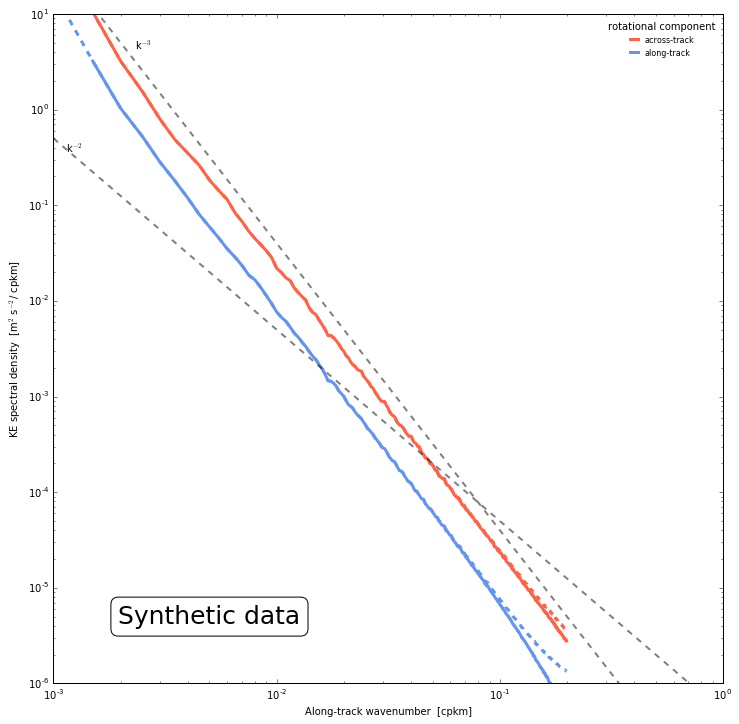

In [39]:
fig = plt.figure(facecolor='w', figsize=(12.,12.))
plt.loglog(ku,Eu,color=color1,label=u'across-track',linewidth=3.)
plt.loglog(kv,Ev,color=color2,label=u'along-track',linewidth=3.)

plt.loglog(ku,Eunn,'--',color=color1,linewidth=3.)
plt.loglog(kv,Evnn,'--',color=color2,linewidth=3.)

plt.axis((1./(1000),1./5.,1.e-6,10.))

plt.loglog(ks2,Es2,'--', color='k',linewidth=2.,alpha=.5)
plt.loglog(ks3,Es3,'--', color='k',linewidth=2.,alpha=.5)

plt.text(0.0023277454363699311, 4.2296271323591785,u'k$^{-3}$')
plt.text(0.0011367633953758597, 0.35651953657755464,u'k$^{-2}$')
plt.ylabel('KE spectral density  [m$^2$ s$^{-2}$/ cpkm]')
plt.xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=1,title= u'rotational component', numpoints=1)
lg.draw_frame(False)

plt.axis((1./1.e3,1.,1./1.e6,1.e1))

plt.text(.5/1.e2, 5./1.e6, "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

figtit = 'figs/EuEv_noise.png'
plt.savefig(figtit,format='png', bbox_inches='tight')

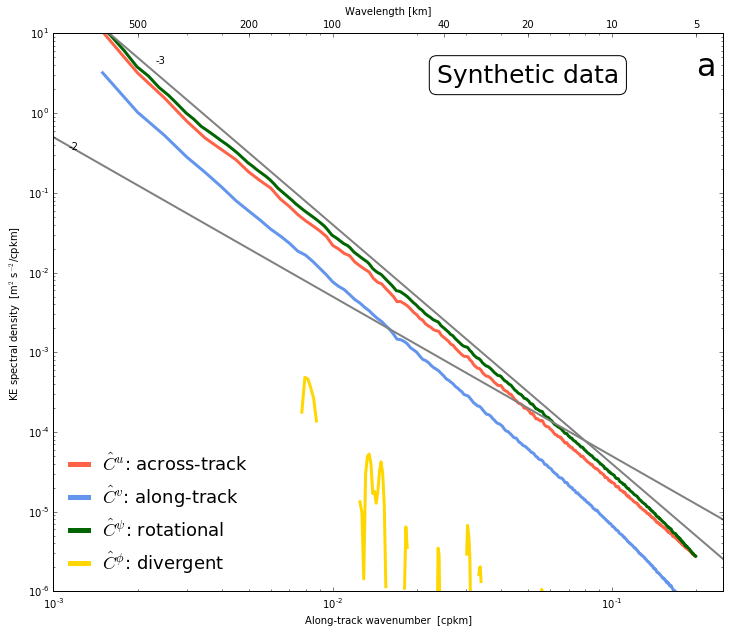

In [40]:

# nd + high-pass d
fig = plt.figure(facecolor='w', figsize=(12.,10.))
ax1 = fig.add_subplot(111)
p1,= ax1.loglog(ku,Eu,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=3.)
ax1.loglog(kv,Ev,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=3.)
ax1.loglog(kK,Kpsi_nd,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=3.)
ax1.loglog(kK,Kphi_nd,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=3.)

#p2, =ax1.loglog(ku,Eun,color=color3,label=u'rot. + high-pass div. (k$^{-3}$), across-track',linewidth=3.)
#plt.loglog(kv,Evn,color=color6,label=u'rot. + high-pass div. (k$^{-3}$), along-track',linewidth=3.)
#p3, = ax1.loglog(ku,Eun2,'-',color=color4,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), across-track',linewidth=3.)
#ax1.loglog(kv,Evn2,'-',color=color5,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), along-track',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=2.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=2.)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464,u'-2')
ax1.set_ylabel('KE spectral density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', prop={'size':18,}, numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(1./5., 3., "a", fontsize=32)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

figtit = 'figs/EuEv_synthetic_a'
plt.savefig(figtit+'.png', bbox_inches='tight')
plt.savefig(figtit+'.eps', bbox_inches='tight')
plt.savefig(figtit+'.pdf', bbox_inches='tight')



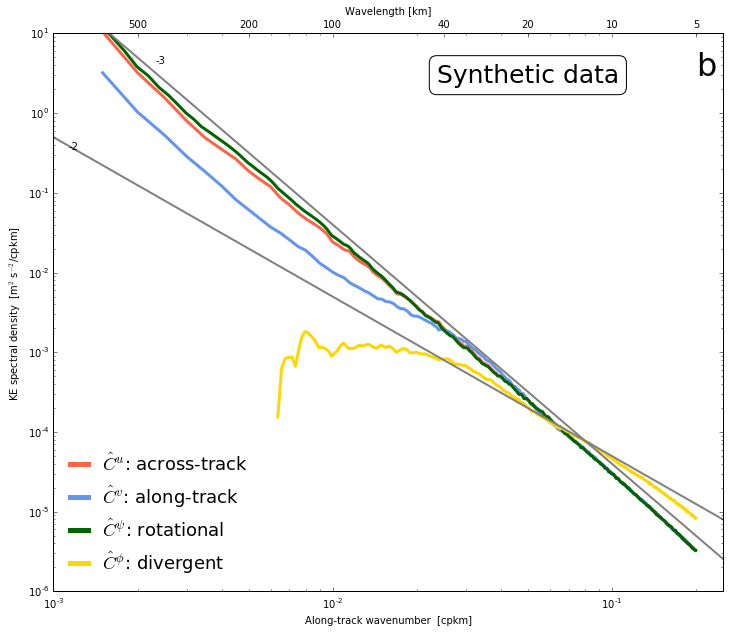

In [41]:
# nd + high-pass d
fig = plt.figure(facecolor='w', figsize=(12.,10.))
ax1 = fig.add_subplot(111)
ax1.loglog(ku,Eun,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=3.)
plt.loglog(kv,Evn,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=3.)
ax1.loglog(kK,Kpsi_d1,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=3.)
ax1.loglog(kK,Kphi_d2,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=3.)


#p3, = ax1.loglog(ku,Eun2,'-',color=color4,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), across-track',linewidth=3.)
#ax1.loglog(kv,Evn2,'-',color=color5,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), along-track',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=2.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=2.)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464,u'-2')
ax1.set_ylabel('KE spectral density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', prop={'size':18,}, numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(1./5., 3., "b", fontsize=32)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))


figtit = 'figs/EuEv_synthetic_b'
plt.savefig(figtit+'.png', bbox_inches='tight')
plt.savefig(figtit+'.eps', bbox_inches='tight')
plt.savefig(figtit+'.pdf', bbox_inches='tight')





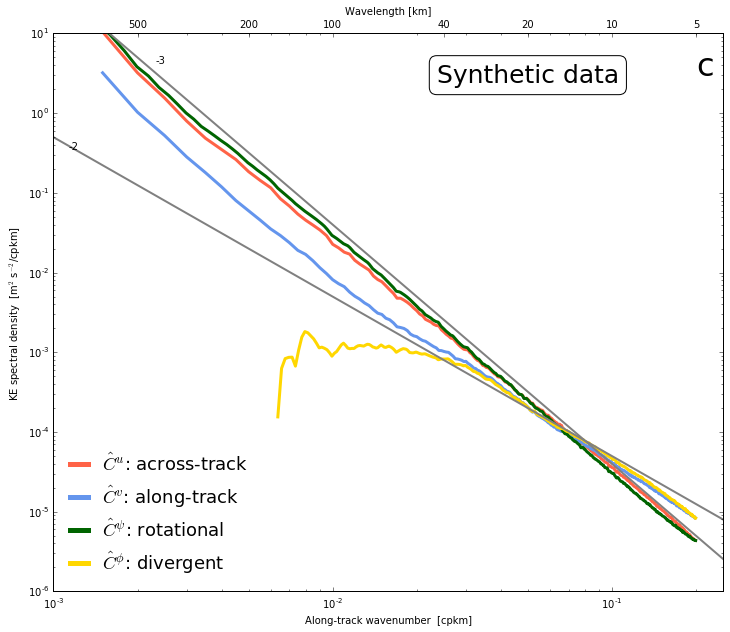

In [42]:
# nd + high-pass d
fig = plt.figure(facecolor='w', figsize=(12.,10.))
ax1 = fig.add_subplot(111)
ax1.loglog(ku,Eun2,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=3.)
plt.loglog(kv,Evn2,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=3.)
ax1.loglog(kK,Kpsi_d2,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=3.)
ax1.loglog(kK,Kphi_d2,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=3.)

ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=2.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=2.)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464,u'-2')
ax1.set_ylabel('KE spectral density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', prop={'size':18,}, numpoints=1)
lg.draw_frame(False)
my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(1./5., 3., "c", fontsize=32)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

figtit = 'figs/EuEv_synthetic_c'
plt.savefig(figtit+'.png', bbox_inches='tight')
plt.savefig(figtit+'.eps', bbox_inches='tight')
plt.savefig(figtit+'.pdf', bbox_inches='tight')



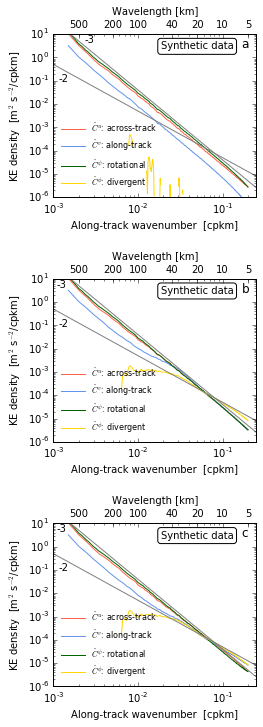

In [62]:
fig = plt.figure(figsize=(8.27/2-.5,11.69))
aph=0.35
xt,yt = 1./6., 2.5


ax1 = fig.add_subplot(311)
p1,= ax1.loglog(ku,Eu,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=1.)
ax1.loglog(kv,Ev,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=1.)
ax1.loglog(kK,Kpsi_nd,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=1.)
ax1.loglog(kK,Kphi_nd,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=1.)

#p2, =ax1.loglog(ku,Eun,color=color3,label=u'rot. + high-pass div. (k$^{-3}$), across-track',linewidth=3.)
#plt.loglog(kv,Evn,color=color6,label=u'rot. + high-pass div. (k$^{-3}$), along-track',linewidth=3.)
#p3, = ax1.loglog(ku,Eun2,'-',color=color4,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), across-track',linewidth=3.)
#ax1.loglog(kv,Evn2,'-',color=color5,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), along-track',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=1.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=1.)

ax1.text(0.0023277454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464/4.,u'-2')
ax1.set_ylabel('KE density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', numpoints=1)
lg.draw_frame(False)
#my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(xt, yt, "a", fontsize=12)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=10, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

# save subplot
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig5a.png', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5a.eps', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5a.pdf', bbox_inches=extent.expanded(1.3, 1.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

ax1 = fig.add_subplot(312)
ax1.loglog(ku,Eun,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=1.)
plt.loglog(kv,Evn,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=1.)
ax1.loglog(kK,Kpsi_d1,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=1.)
ax1.loglog(kK,Kphi_d2,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=1.)


#p3, = ax1.loglog(ku,Eun2,'-',color=color4,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), across-track',linewidth=3.)
#ax1.loglog(kv,Evn2,'-',color=color5,label=u'rot. + 0.25 x high-pass div. (k$^{-2}$), along-track',linewidth=3.)
ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=1.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=1.)

ax1.text(0.001077454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464/4.,u'-2')
ax1.set_ylabel('KE density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', numpoints=1)
lg.draw_frame(False)
#my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(xt, yt, "b", fontsize=12)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=10, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

# save subplot
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig5b.png', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5b.eps', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5b.pdf', bbox_inches=extent.expanded(1.3, 1.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

ax1 = fig.add_subplot(313)
ax1.loglog(ku,Eun2,color=color1,label=u'$\hat{C}^u$: across-track',linewidth=1.)
plt.loglog(kv,Evn2,color=color2,label=u'$\hat{C}^v$: along-track',linewidth=1.)
ax1.loglog(kK,Kpsi_d2,color=color6,label=u'$\hat{C}^{\psi}$: rotational',linewidth=1.)
ax1.loglog(kK,Kphi_d2,color=color3,label=u'$\hat{C}^{\phi}$: divergent',linewidth=1.)

ax1.axis((1./(1000),1./5.,1.e-6,10.))

ax1.loglog(ks2,Es2,'-', color='0.5',linewidth=1.)
ax1.loglog(ks3,Es3,'-', color='0.5',linewidth=1.)

ax1.text(0.001077454363699311, 4.2296271323591785,u'-3')
ax1.text(0.0011367633953758597, 0.35651953657755464/4.,u'-2')

ax1.set_ylabel('KE density  [m$^2$ s$^{-2}$/cpkm]')
ax1.set_xlabel('Along-track wavenumber  [cpkm]')
lg = plt.legend(loc=3,title= u'', numpoints=1)
lg.draw_frame(False)
#my.leg_width(lg,5.)

ax1.axis((1./1.e3,1./4.,1./1.e6,1.e1))

ax1.text(xt,yt, "c", fontsize=12)

add_second_axis(ax1)

ax1.text(1./20., 3., "Synthetic data", size=10, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

# save subplot
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig5c.png', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5c.eps', bbox_inches=extent.expanded(1.3, 1.5))
fig.savefig('fig5c.pdf', bbox_inches=extent.expanded(1.3, 1.5))

figtit = 'figs/EuEv_synthetic'
plt.savefig(figtit+'.png', bbox_inches='tight')
plt.savefig(figtit+'.eps', bbox_inches='tight')
plt.savefig(figtit+'.pdf', bbox_inches='tight')

